https://medium.com/@zachary.james.angell/applying-survival-analysis-to-customer-churn-40b5a809b05a

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines

In [2]:
churn_data = pd.read_csv(
    'https://raw.githubusercontent.com/treselle-systems/'
    'customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
# transform tenure and churn features
churn_data['tenure'] = churn_data['tenure'].astype(float)
churn_data['Churn'] = churn_data['Churn'] == 'Yes'
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,False
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,True


In [3]:
churn_data.groupby('tenure').agg({'customerID': ['count', 'nunique']}).tail()

customerID        
            count nunique
tenure                   
68.0          100     100
69.0           95      95
70.0          119     119
71.0          170     170
72.0          362     362

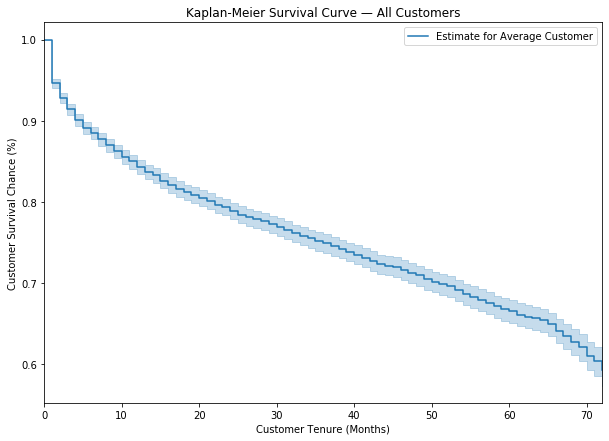

In [4]:
# fitting kmf to churn data
index = churn_data['customerID'] != ''
t = churn_data[index]['tenure'].values
churn = churn_data[index]['Churn'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(t, event_observed=churn, label='Estimate for Average Customer')

# plotting kmf curve
fig, ax = plt.subplots(figsize=(10,7))
kmf.plot(ax=ax)
ax.set_title('Kaplan-Meier Survival Curve — All Customers')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance (%)')
plt.show()

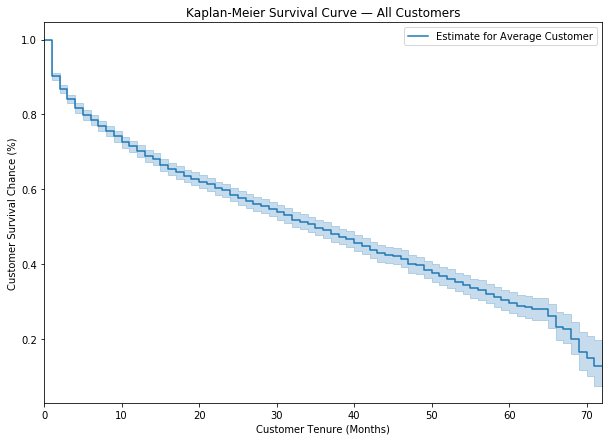

In [5]:
# fitting kmf to churn data
index = churn_data['Contract'] == 'Month-to-month'
t = churn_data[index]['tenure'].values
churn = churn_data[index]['Churn'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(t, event_observed=churn, label='Estimate for Average Customer')

# plotting kmf curve
fig, ax = plt.subplots(figsize=(10,7))
kmf.plot(ax=ax)
ax.set_title('Kaplan-Meier Survival Curve — All Customers')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance (%)')
plt.show()

In [6]:
churn_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
# Subseting Of The Columns To Train The Model
features_to_drop = ['customerID', 'gender', 'PhoneService', 'InternetService']

# Engineering Numeric Columns For Cox Model
churn_surv_data = churn_data.drop(features_to_drop, axis=1).copy()

# Convert Variable To Integers
churn_surv_data['TotalCharges'] = pd.to_numeric(churn_surv_data['TotalCharges'], errors='coerce')
churn_surv_data['TotalCharges'].fillna(0, inplace=True)

# Encoded Variables As 'Yes' Or 'No'
binary_features = ['Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                   'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
                   
for feat in binary_features:
    churn_surv_data[feat] = churn_surv_data[feat] == 'Yes'
    
# One Hot Encoding For Categorical Features
ohe_features = ['MultipleLines', 'Contract', 'PaymentMethod']
churn_surv_data = pd.get_dummies(churn_surv_data, 
                              drop_first=True,
                              columns=ohe_features)

churn_surv_data = churn_surv_data[(churn_surv_data.tenure > 0)]

In [8]:
churn_surv_data.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'MultipleLines_No phone service', 'MultipleLines_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [11]:
cph = lifelines.CoxPHFitter(penalizer = 0.1)
# cph = lifelines.CoxPHFitter()
cph.fit(churn_surv_data.loc[:, :], duration_col='tenure', event_col='Churn', show_progress=True)
cph.print_summary()

Iteration 1: norm_delta = 2.81286, step_size = 0.9500, ll = -15653.03964, newton_decrement = 2316.48990, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.09059, step_size = 0.9500, ll = -13353.38410, newton_decrement = 449.65773, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.95829, step_size = 0.9500, ll = -12837.08482, newton_decrement = 116.77753, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.36783, step_size = 1.0000, ll = -12700.89270, newton_decrement = 11.13344, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.04588, step_size = 1.0000, ll = -12688.88036, newton_decrement = 0.15831, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.00100, step_size = 1.0000, ll = -12688.70612, newton_decrement = 0.00008, seconds_since_start = 0.1
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -12688.70582, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence success after 7 iterations.


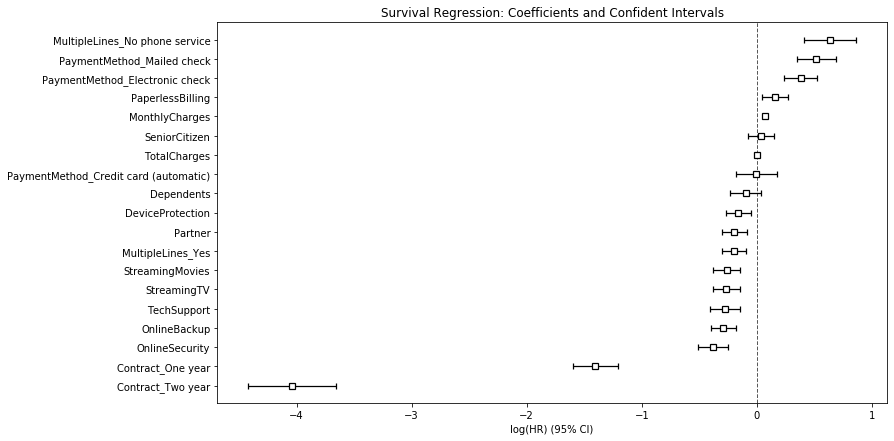

In [10]:
# plotting coefficients
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confident Intervals')
cph.plot(ax=ax_coef);

In [12]:
cph.summary[cph.summary['p'] <= 0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
Partner,-0.194194,0.823498,0.055056,-0.302101,-0.086287,0.739263,0.917331,-3.527224,4.199410e-04,11.217526
OnlineSecurity,-0.379731,0.684045,0.067208,-0.511455,-0.248006,0.599622,0.780355,-5.650114,1.603412e-08,25.894279
OnlineBackup,-0.292010,0.746761,0.055955,-0.401681,-0.182340,0.669194,0.833318,-5.218624,1.802571e-07,22.403441
DeviceProtection,-0.159764,0.852345,0.056066,-0.269651,-0.049878,0.763646,0.951346,-2.849596,4.377486e-03,7.835682
TechSupport,-0.276108,0.758731,0.065854,-0.405181,-0.147036,0.666856,0.863263,-4.192710,2.756419e-05,15.146845
StreamingTV,-0.266596,0.765982,0.059938,-0.384072,-0.149120,0.681083,0.861465,-4.447891,8.671734e-06,16.815248
StreamingMovies,-0.260052,0.771011,0.059672,-0.377008,-0.143096,0.685911,0.866671,-4.357993,1.312607e-05,16.217206
PaperlessBilling,0.158623,1.171896,0.056766,0.047364,0.269883,1.048503,1.309811,2.794330,5.200734e-03,7.587069
MonthlyCharges,0.066701,1.068976,0.002509,0.061783,0.071619,1.063732,1.074246,26.583337,1.057919e-155,514.817625
TotalCharges,-0.001535,0.998467,0.000038,-0.001610,-0.001460,0.998392,0.998541,-40.104580,0.000000e+00,inf


In [13]:
cols = cph.summary[cph.summary['p'] <= 0.05].index.values
cols = np.concatenate((cols, ['Churn', 'tenure']), axis=0)
print(cols)
cph2 = lifelines.CoxPHFitter(penalizer = 0.1)
# cph = lifelines.CoxPHFitter()
cph2.fit(churn_surv_data.loc[:, cols], duration_col='tenure', event_col='Churn', show_progress=False)

['Partner' 'OnlineSecurity' 'OnlineBackup' 'DeviceProtection'
 'TechSupport' 'StreamingTV' 'StreamingMovies' 'PaperlessBilling'
 'MonthlyCharges' 'TotalCharges' 'MultipleLines_No phone service'
 'MultipleLines_Yes' 'Contract_One year' 'Contract_Two year'
 'PaymentMethod_Electronic check' 'PaymentMethod_Mailed check' 'Churn'
 'tenure']


<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>

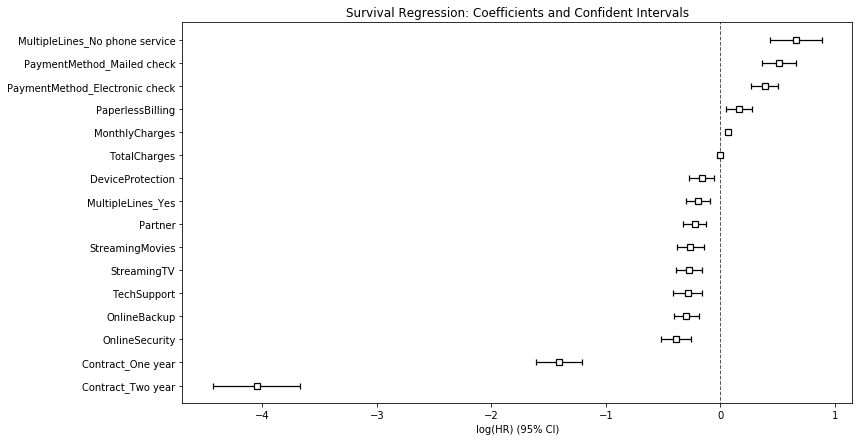

In [29]:
# plotting coefficients
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confident Intervals')
cph2.plot(ax=ax_coef);

In [14]:
# Pediction
tr_rows1 = churn_surv_data
pred_cxh = cph2.predict_survival_function(tr_rows1)
# pred_cxh
# Filtered ~ 1 % of the data 
filtered_pred_cxh = pred_cxh.loc[:, (pred_cxh.gt(0.588199) & pred_cxh.lt(0.999998)).all(0)]
filtered_pred_cxh

,12,23,48,54,56,57,62,73,75,87,...,6911,6931,6942,6947,6972,6976,6992,7022,7034,7037
1.0,0.999976,0.999996,0.999996,0.999980,0.999992,0.999995,0.999995,0.999983,0.999978,0.999976,...,0.999974,0.999981,0.999980,0.999995,0.999979,0.999998,0.999998,0.999997,0.999982,0.999979
2.0,0.999964,0.999994,0.999995,0.999970,0.999988,0.999993,0.999993,0.999975,0.999967,0.999965,...,0.999962,0.999972,0.999970,0.999993,0.999969,0.999997,0.999996,0.999995,0.999973,0.999969
3.0,0.999953,0.999992,0.999993,0.999960,0.999984,0.999991,0.999991,0.999967,0.999957,0.999953,...,0.999950,0.999963,0.999961,0.999990,0.999960,0.999996,0.999995,0.999994,0.999965,0.999959
4.0,0.999941,0.999990,0.999991,0.999950,0.999980,0.999988,0.999989,0.999959,0.999946,0.999941,...,0.999936,0.999954,0.999951,0.999988,0.999949,0.999995,0.999994,0.999993,0.999956,0.999949
5.0,0.999929,0.999988,0.999989,0.999940,0.999976,0.999986,0.999987,0.999951,0.999936,0.999930,...,0.999924,0.999944,0.999941,0.999986,0.999940,0.999994,0.999993,0.999991,0.999947,0.999939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68.0,0.853185,0.972513,0.976581,0.874266,0.947147,0.969186,0.970677,0.895375,0.865371,0.854303,...,0.843077,0.882821,0.876195,0.968217,0.873158,0.986570,0.984470,0.980129,0.888641,0.871324
69.0,0.822639,0.966308,0.971282,0.847703,0.935411,0.962245,0.964067,0.872940,0.837111,0.823965,...,0.810671,0.857915,0.850003,0.961063,0.846383,0.983512,0.980938,0.975622,0.864874,0.844197
70.0,0.763068,0.953641,0.960446,0.795456,0.911670,0.948092,0.950578,0.828442,0.781723,0.764772,...,0.747736,0.808758,0.798447,0.946479,0.793740,0.977236,0.973696,0.966396,0.817859,0.790902
71.0,0.716864,0.943242,0.951534,0.754501,0.892402,0.936490,0.939514,0.793198,0.738499,0.718835,...,0.699175,0.770063,0.757995,0.934529,0.752498,0.972052,0.967719,0.958796,0.780744,0.749188


Text(0, 0.5, 'Probablity still a customer')

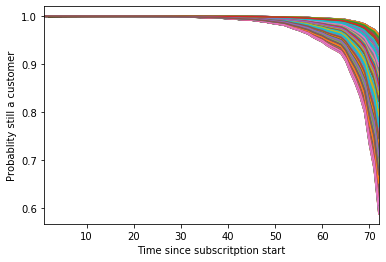

In [175]:
# Plot individual survival curves 
p1 = filtered_pred_cxh.plot(legend=None)
plt.xlabel('Time since subscritption start')
plt.ylabel('Probablity still a customer')

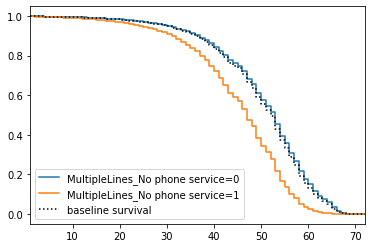

In [21]:
ax = cph2.plot_covariate_groups('MultipleLines_No phone service', [0, 1])
ax

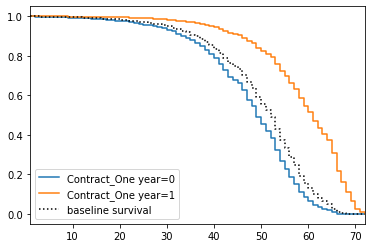

In [22]:
ax = cph2.plot_covariate_groups('Contract_One year', [0, 1])
ax

Text(0.5, 1.0, 'Calibration plots (reliability curve)')

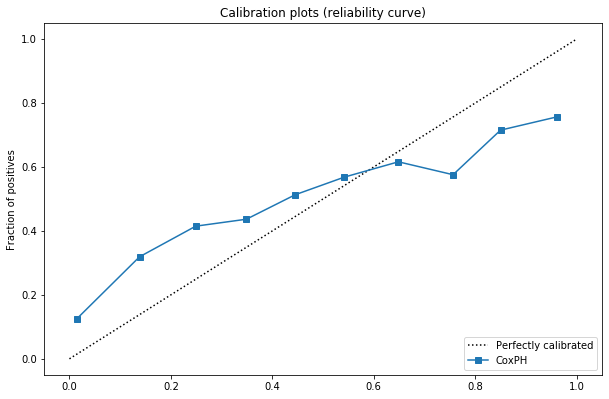

In [36]:
from sklearn.calibration import calibration_curve 
plt.figure(figsize=(10, 10))
 
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2) 
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated") 
probs = 1-np.array(cph2.predict_survival_function(churn_surv_data).loc[13])
actual = churn_surv_data['Churn'] == 1 
fraction_of_positives, mean_predicted_value = calibration_curve(actual, probs, n_bins=10, normalize=False) 
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % ("CoxPH",)) 
ax1.set_ylabel("Fraction of positives") 
ax1.set_ylim([-0.05, 1.05]) 
ax1.legend(loc="lower right") 
ax1.set_title('Calibration plots (reliability curve)')

In [37]:
from sklearn.metrics import brier_score_loss

In [38]:
brier_score_loss( 
    churn_surv_data['Churn'] == 1 ,
    1 - np.array(cph2.predict_survival_function(churn_surv_data).loc[13]),
    pos_label=1 
)

0.16476595336573677

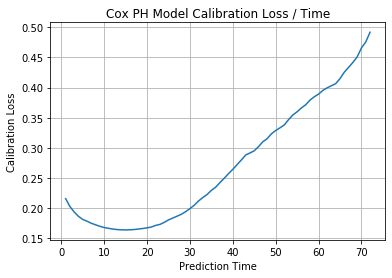

In [39]:
loss_dict = {} 
for i in range(1,73): 
    score = brier_score_loss( 
        churn_surv_data['Churn'] == 1 ,
        1 - np.array(cph2.predict_survival_function(churn_surv_data).loc[i]),
        pos_label=1 
    )
    loss_dict[i] = [score] 
loss_df = pd.DataFrame(loss_dict).T 
fig, ax = plt.subplots() 
ax.plot(loss_df.index, loss_df) 
ax.set(xlabel='Prediction Time', ylabel='Calibration Loss', title='Cox PH Model Calibration Loss / Time') 
ax.grid() 
plt.show()